In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Danh sách tên file (đảm bảo file nằm cùng thư mục với notebook)
files = [
    'datalake/weather_batch_20251121_210547.csv', # HCMC
    'datalake/weather_batch_20251121_211327.csv', # Tokyo
    'datalake/weather_batch_20251121_212059.csv'  # Paris
]


In [2]:
dfs = []
for f in files:
    df = pd.read_csv(f)
    # Chuyển cột Time sang dạng datetime
    df['Time'] = pd.to_datetime(df['Time'])
    dfs.append(df)

# Gộp thành 1 DataFrame lớn
df_all = pd.concat(dfs, ignore_index=True)

# Tách thông tin Tháng và Giờ từ cột Time để dùng cho các biểu đồ sau
df_all['Month'] = df_all['Time'].dt.month
df_all['Hour'] = df_all['Time'].dt.hour

# Kiểm tra dữ liệu sau khi gộp
print("Dữ liệu đã gộp thành công!")
print(df_all.groupby('City')['Temperature'].describe()) # Xem thống kê sơ bộ

# Thiết lập giao diện biểu đồ cho đẹp
sns.set_theme(style="whitegrid")

Dữ liệu đã gộp thành công!
             count       mean       std   min   25%   50%   75%   max
City                                                                 
Paris      51648.0  12.872686  7.047121  -5.7   7.9  12.5  17.7  39.1
Tokyo      51648.0  16.145032  9.028053  -7.8   8.7  16.5  23.6  39.2
hochiminh  51648.0  27.534005  2.998787  17.8  25.3  26.9  29.5  39.2


In [ ]:
# Đọc và hiển thị 5 dòng đầu tiên của bảng dữ liệu tổng hợp
print("5 dòng đầu tiên của dữ liệu")
print(df_all.head(5))

--- 5 dòng đầu tiên của dữ liệu ---
        City                Time  Temperature  Humidity  Wind Speed  Month  \
0  hochiminh 2020-01-01 00:00:00         24.0        68        11.0      1   
1  hochiminh 2020-01-01 01:00:00         26.2        60        14.8      1   
2  hochiminh 2020-01-01 02:00:00         28.3        53        13.6      1   
3  hochiminh 2020-01-01 03:00:00         30.3        46        11.8      1   
4  hochiminh 2020-01-01 04:00:00         32.4        36        12.5      1   

   Hour         Condition  
0     0       Bình thường  
1     1       Bình thường  
2     2       Bình thường  
3     3       Bình thường  
4     4  Rất Nóng (>32°C)  


In [10]:
# Cách kiểm tra dữ liệu mỗi thành phố sau khi gộp: Lấy ra 3 dòng đầu tiên của MỖI thành phố
print(df_all.groupby('City').head(3))

             City                Time  Temperature  Humidity  Wind Speed  \
0       hochiminh 2020-01-01 00:00:00         24.0        68        11.0   
1       hochiminh 2020-01-01 01:00:00         26.2        60        14.8   
2       hochiminh 2020-01-01 02:00:00         28.3        53        13.6   
51648       Tokyo 2020-01-01 00:00:00          4.3        50        13.4   
51649       Tokyo 2020-01-01 01:00:00          5.1        50        12.6   
51650       Tokyo 2020-01-01 02:00:00          6.0        50        10.9   
103296      Paris 2020-01-01 00:00:00          2.6        98         3.7   
103297      Paris 2020-01-01 01:00:00          2.1       100         3.8   
103298      Paris 2020-01-01 02:00:00          1.9       100         4.9   

        Month  Hour        Condition  
0           1     0      Bình thường  
1           1     1      Bình thường  
2           1     2      Bình thường  
51648       1     0  Rất Lạnh (<5°C)  
51649       1     1      Bình thường  
51650

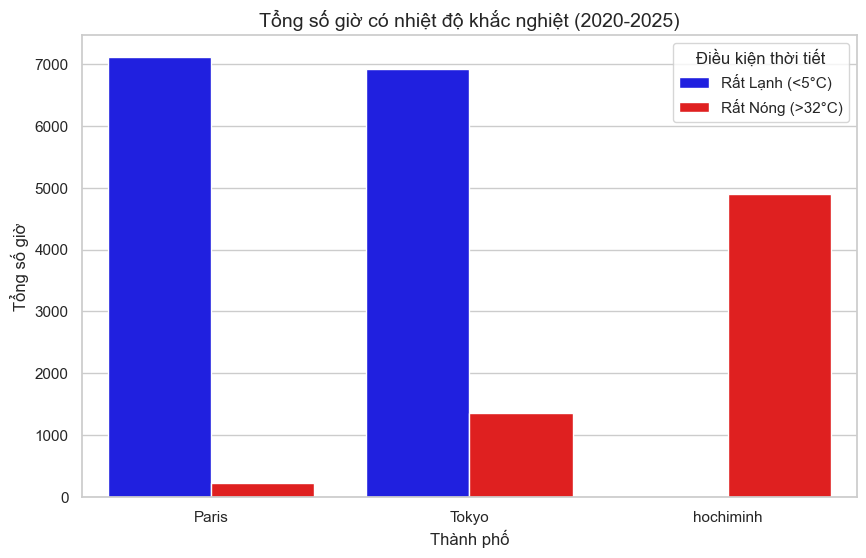

In [3]:
# --- BIỂU ĐỒ 1: SO SÁNH SỐ GIỜ KHẮC NGHIỆT ---

# 1. Định nghĩa hàm phân loại thời tiết
def classify_weather(temp):
    if temp >= 32: 
        return 'Rất Nóng (>32°C)'
    if temp <= 5: 
        return 'Rất Lạnh (<5°C)'
    return 'Bình thường'

# 2. Áp dụng hàm này vào dữ liệu
df_all['Condition'] = df_all['Temperature'].apply(classify_weather)

# 3. Lọc bỏ những giờ "Bình thường", chỉ giữ lại cái khắc nghiệt
df_extremes = df_all[df_all['Condition'] != 'Bình thường']

# 4. Đếm số giờ xuất hiện
# reset_index(name='Hours') giúp đặt tên cột số lượng là 'Hours'
extreme_counts = df_extremes.groupby(['City', 'Condition']).size().reset_index(name='Hours')

# 5. Vẽ biểu đồ cột
plt.figure(figsize=(10, 6))
sns.barplot(data=extreme_counts, x='City', y='Hours', hue='Condition', 
            palette={'Rất Nóng (>32°C)': 'red', 'Rất Lạnh (<5°C)': 'blue'})

plt.title('Tổng số giờ có nhiệt độ khắc nghiệt (2020-2025)', fontsize=14)
plt.ylabel('Tổng số giờ')
plt.xlabel('Thành phố')
plt.legend(title='Điều kiện thời tiết')
plt.show()

Biểu đồ này thể hiện tổng số giờ nhiệt dộ trong năm, diễn giải ra thành phố có nhiệt độ quá cao hay thấp 

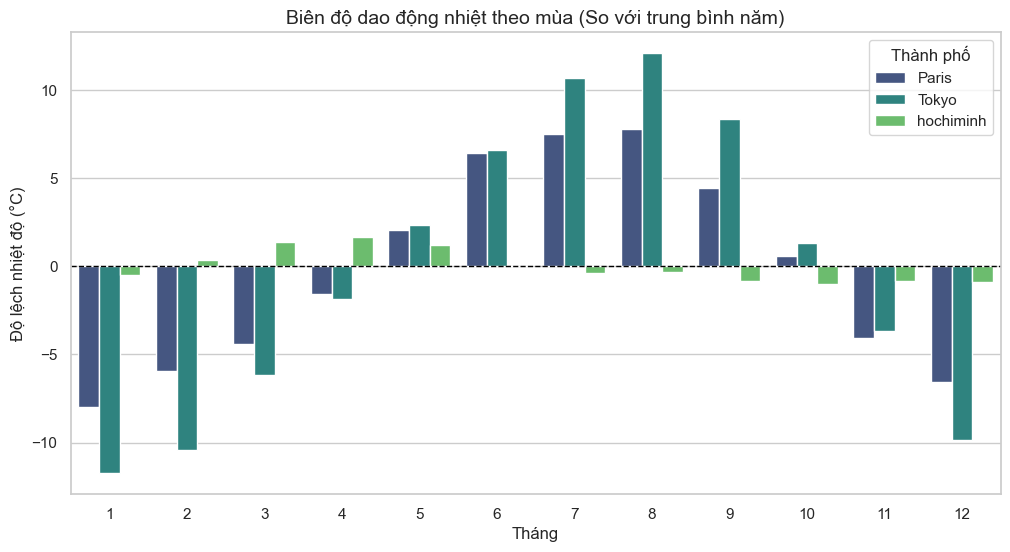

In [4]:
# --- BIỂU ĐỒ 2: ĐỘ LỆCH NHIỆT ĐỘ THEO MÙA (SEASONAL ANOMALY) ---

# 1. Tính nhiệt độ trung bình của từng tháng cho mỗi thành phố
monthly_mean = df_all.groupby(['City', 'Month'])['Temperature'].mean().reset_index()

# 2. Tính nhiệt độ trung bình cả năm (benchmark) của mỗi thành phố
yearly_mean = df_all.groupby('City')['Temperature'].mean().to_dict()

# 3. Tính độ lệch (Deviation) = Nhiệt độ tháng - Nhiệt độ trung bình năm
# Nếu dương (+) là mùa nóng hơn bình thường, âm (-) là mùa lạnh hơn bình thường
monthly_mean['Deviation'] = monthly_mean.apply(lambda x: x['Temperature'] - yearly_mean[x['City']], axis=1)

# 4. Vẽ biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(data=monthly_mean, x='Month', y='Deviation', hue='City', palette='viridis')

# Vẽ thêm đường kẻ ngang ở mốc 0 để dễ nhìn sự chênh lệch
plt.axhline(0, color='black', linestyle='--', linewidth=1)

# Trang trí
plt.title('Biên độ dao động nhiệt theo mùa (So với trung bình năm)', fontsize=14)
plt.ylabel('Độ lệch nhiệt độ (°C)')
plt.xlabel('Tháng')
plt.legend(title='Thành phố')

# Hiển thị
plt.show()

Biểu đồ này loại bỏ yếu tố nhiệt độ tuyệt đối (ví dụ: 30 độ là nóng ở Paris nhưng bình thường ở HCMC) để so sánh về tính ổn định,có biến động mạnh theo mùa không, hay quanh năm như một?

In [5]:
# Chạy dòng này để tách Giờ và Tháng từ cột Time ra
df_all['Hour'] = df_all['Time'].dt.hour
df_all['Month'] = df_all['Time'].dt.month

# Kiểm tra xem đã có cột Hour chưa
print(df_all.head())

        City                Time  Temperature  Humidity  Wind Speed  Month  \
0  hochiminh 2020-01-01 00:00:00         24.0        68        11.0      1   
1  hochiminh 2020-01-01 01:00:00         26.2        60        14.8      1   
2  hochiminh 2020-01-01 02:00:00         28.3        53        13.6      1   
3  hochiminh 2020-01-01 03:00:00         30.3        46        11.8      1   
4  hochiminh 2020-01-01 04:00:00         32.4        36        12.5      1   

   Hour         Condition  
0     0       Bình thường  
1     1       Bình thường  
2     2       Bình thường  
3     3       Bình thường  
4     4  Rất Nóng (>32°C)  


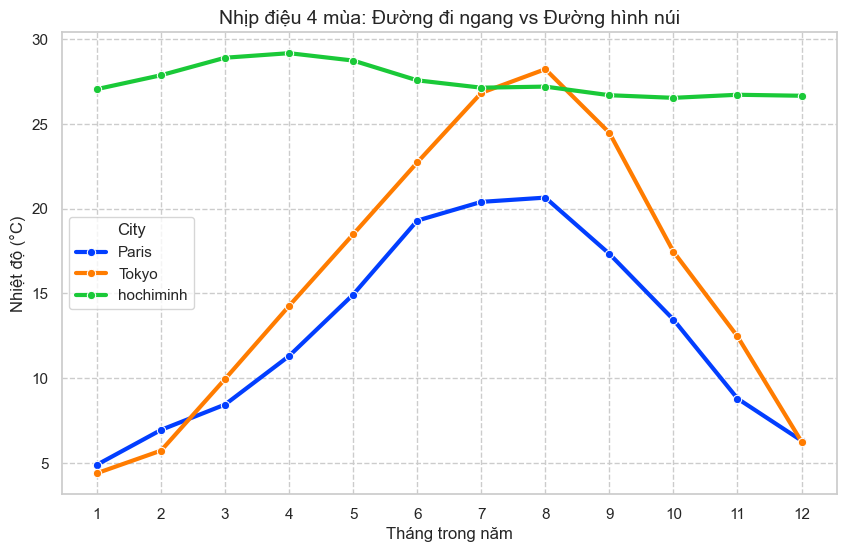

In [6]:
# --- BIỂU ĐỒ 3: DIỄN BIẾN THỜI TIẾT TRONG NĂM ---
# Lấy tháng ra để nhóm (Bỏ qua năm, gộp chung 2020-2025 lại)
df_all['Month'] = df_all['Time'].dt.month
monthly_pattern = df_all.groupby(['City', 'Month'])['Temperature'].mean().reset_index()

plt.figure(figsize=(10, 6))
# Vẽ đường đậm (linewidth=3) cho dễ nhìn
sns.lineplot(data=monthly_pattern, x='Month', y='Temperature', hue='City', 
             marker='o', linewidth=3, palette='bright')

plt.title('Nhịp điệu 4 mùa: Đường đi ngang vs Đường hình núi', fontsize=14)
plt.ylabel('Nhiệt độ (°C)')
plt.xlabel('Tháng trong năm')
plt.xticks(range(1, 13)) # Hiện đủ 12 số tháng
plt.grid(True, linestyle='--') # Kẻ lưới mờ để dễ dóng hàng
plt.show()

Gộp tất cả các năm lại thành một năm đại diện (từ tháng 1 đến tháng 12), biểu thị chênh lệch nhiệt độ từng tháng của các thành phố 

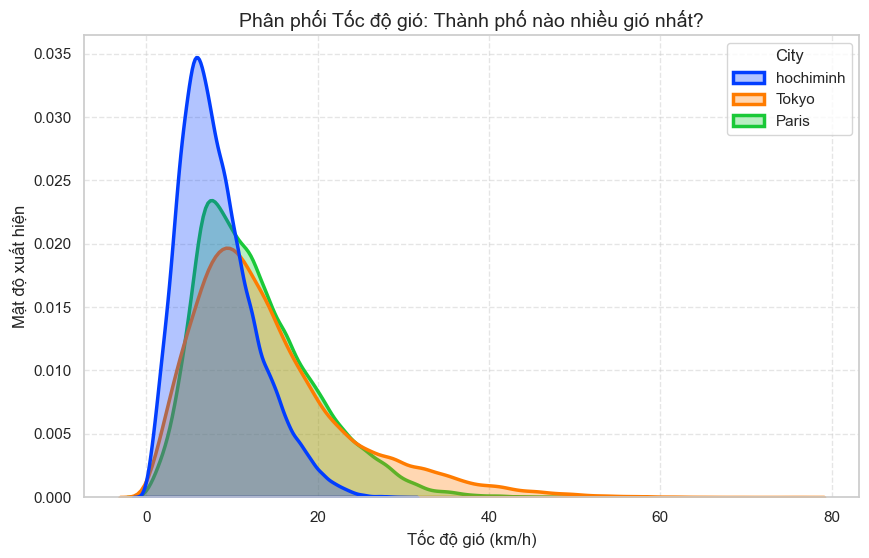

In [7]:
# --- BIỂU ĐỒ 4: SO SÁNH SỨC GIÓ (Biểu đồ Phân phối) ---
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ KDE (Kernel Density Estimate) - Làm mượt dữ liệu để dễ nhìn hơn cột
sns.kdeplot(data=df_all, x='Wind Speed', hue='City', 
            fill=True, alpha=0.3, linewidth=2.5, palette='bright')

plt.title('Phân phối Tốc độ gió: Thành phố nào nhiều gió nhất?', fontsize=14)
plt.xlabel('Tốc độ gió (km/h)')
plt.ylabel('Mật độ xuất hiện')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Mật độ gió giữa các thành phố: HCM yếu nhất,Paris,Tokyo mạnh nhất (tính toán chi phí chống gió bão)